# Introduction
    1. Training data and testing data have been removed the exception data
    2. Because the files are too big, it doesn't need to run the sections with option.
    3. The product ID in the total csv files have different types: int & str. It needs to tranform the type of int to the type of str.
    4. The features may distribute differently in the training and testing data, e.g.
        (1) Day
        (2) CustomerID
    5. The features already consider
        (1) Max, Mean, Std of the days opening the files
        (2) Max, Min, Mean, Std of time interval
        (3) ProductID
        (4) Top_1000_dangerous_CustomerID

In [39]:
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
# from matplotlib_venn import venn2, venn3
from datetime import date

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

from tqdm import tqdm_notebook

%matplotlib inline
pd.set_option("display.max_columns",150)

# Load data

### 1.1 Load original training data
    If it is the first time to load training data, then run this section, otherwise skip the following section until the section 4.

In [40]:
df_train = pd.read_csv('/data/examples/trend/data/training-set.csv', header=None)
df_train.columns = ['FileID', 'Label']
df_train.head()

,FileID,Label
0,0000e2398b12121a85166fed5fe2a3da,0
1,0001fe8dce14ce099aa6ca8ea5026ea7,0
2,00027f50019000accc492e5684efc818,0
3,00028c9da3573ec50db74b44310ae507,0
4,0003dc8130969abe688cadf5f14ea19f,0


### 1.2 Load testing data

In [41]:
df_test = pd.read_csv('/data/examples/trend/data/testing-set.csv', header=None)
df_test.columns = ['FileID', 'Label']
df_test.head()

,FileID,Label
0,00008c73ee43c15b16c26b26398c1577,0.5
1,0002ded3a0b54f2ffdab0ca77a5ce2b6,0.5
2,00050a9df8e13f6ab5a3d3b3e2fc6a86,0.5
3,000b1aa62b95e448784b8b341de46c64,0.5
4,000d9f96b5eddf04a3b7a37cb95d0a00,0.5


### 1.4 Load query_log data

In [42]:
query_log_list = os.listdir('/data/examples/trend/data/query_log')
# Sort by the date
query_log_list.sort()
print(query_log_list)

['0301.csv', '0302.csv', '0303.csv', '0304.csv', '0305.csv', '0306.csv', '0307.csv', '0308.csv', '0309.csv', '0310.csv', '0311.csv', '0312.csv', '0313.csv', '0314.csv', '0315.csv', '0316.csv', '0317.csv', '0318.csv', '0319.csv', '0320.csv', '0321.csv', '0322.csv', '0323.csv', '0324.csv', '0325.csv', '0326.csv', '0327.csv', '0328.csv', '0329.csv', '0330.csv', '0331.csv', '0401.csv', '0402.csv', '0403.csv', '0404.csv', '0405.csv', '0406.csv', '0407.csv', '0408.csv', '0409.csv', '0410.csv', '0411.csv', '0412.csv', '0413.csv', '0414.csv', '0415.csv', '0416.csv', '0417.csv', '0418.csv', '0419.csv', '0420.csv', '0421.csv', '0422.csv', '0423.csv', '0424.csv', '0425.csv', '0426.csv', '0427.csv', '0428.csv', '0429.csv', '0430.csv', '0501.csv', '0502.csv', '0503.csv', '0504.csv', '0505.csv', '0506.csv', '0507.csv', '0508.csv', '0509.csv', '0510.csv', '0511.csv', '0512.csv', '0513.csv', '0514.csv', '0515.csv', '0516.csv', '0517.csv', '0518.csv', '0519.csv', '0520.csv', '0521.csv', '0522.csv', '05

In [43]:
path = '/data/examples/trend/data/query_log/'
df_query_log = pd.DataFrame()

for i in tqdm_notebook(range(len(query_log_list))):
    # get the date and store it in the column 4 of df
    day = query_log_list[i].split('.')[0]
    df = pd.read_csv(path+query_log_list[i], encoding='utf-8', header=None)
    df[4] = day
    df_query_log = pd.concat([df_query_log, df], ignore_index=True)

HBox(children=(IntProgress(value=0, max=92), HTML(value='')))

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### It is faster to load query_log files first then set the column names than to set the column names first. 
#### I don't know why...?

In [44]:
df_query_log.columns = ['FileID', 'CustomerID', 'QueryTs', 'ProductID', 'Day']
df_query_log['Times'] = 1
df_query_log.head()

,FileID,CustomerID,QueryTs,ProductID,Day,Times
0,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326402,c105a0,0301,1
1,29962f9102502ee76bb3cddb8cf8c9ad,597df153a25e8e548cbe35f6e4da9cbb,1488326403,c105a0,0301,1
2,fa3fa642378b9d98c0e2770611b92eb3,1db24b8cc0a7ce59634629e7f292520f,1488326405,c105a0,0301,1
3,48f90ea1af2c04677c6890db392ca088,5ca6dd0b8863069ab1efe014de82cecf,1488326411,c76d58,0301,1
4,d0ff310c25e3bd7ae919d34dc38fb0de,5ca6dd0b8863069ab1efe014de82cecf,1488326411,c76d58,0301,1


In [45]:
# Change the type of int to the type of str
df_query_log['ProductID'] = df_query_log['ProductID'].astype('str')

### 1.5 Some useful constant numbers

In [8]:
start_time = 1488326402
end_time   = 1496275198

total_query_log    = len(df_query_log)
total_FileID       = len(df_query_log['FileID'].unique())
total_train_FileID = len(df_train)
total_test_FileID  = len(df_test)
total_nonvirus     = sum(df_train['Label']==0)
total_virus        = sum(df_train['Label']==1)
total_CustomerID   = len(df_query_log['CustomerID'].unique())
total_QueryTS      = len(df_query_log['QueryTs'].unique())
total_ProductID    = len(df_query_log['ProductID'].unique())
                         
print('Total query log    :', total_query_log)
print('Total FileID       :', total_FileID)
print('Total train FileID :', total_train_FileID)
print('Total test FileID  :', total_test_FileID)
print('Total nonvirus     :', total_nonvirus)
print('Total virus        :', total_virus)
print('Total CustomerID   :', total_CustomerID)
print('Total QueryTs      :', total_QueryTS)
print('Total ProductID    :', total_ProductID)

Total query log    : 83273110
Total FileID       : 81894
Total train FileID : 52518
Total test FileID  : 29376
Total nonvirus     : 46878
Total virus        : 5640
Total CustomerID   : 5539312
Total QueryTs      : 7848319
Total ProductID    : 29


# 2. Observe data

### 2.1 Very Imbalance: #0 : #1 = 9 : 1

In [9]:
print('In training data:')
print('#0: ', total_nonvirus, '(%s)' % str(total_nonvirus / total_train_FileID))
print('#1:  ',total_virus,    '(%s)' % str(total_virus / total_train_FileID))

In training data:
#0:  46878 (0.8926082486)
#1:   5640 (0.1073917514)


### 2.2 FileID vs Day

In [46]:
df_FileID_Day = df_query_log.pivot_table(values='Times', index=['FileID'], columns='Day', aggfunc='sum')
# df_FileID_Day = df_FileID_Day.fillna(0)

In [47]:
df_FileID_Day.head(1)

Day,0301,0302,0303,0304,0305,0306,0307,0308,0309,0310,0311,0312,0313,0314,0315,0316,0317,0318,0319,0320,0321,0322,0323,0324,0325,0326,0327,0328,0329,0330,0331,0401,0402,0403,0404,0405,0406,0407,0408,0409,0410,0411,0412,0413,0414,0415,0416,0417,0418,0419,0420,0421,0422,0423,0424,0425,0426,0427,0428,0429,0430,0501,0502,0503,0504,0505,0506,0507,0508,0509,0510,0511,0512,0513,0514,0515,0516,0517,0518,0519,0520,0521,0522,0523,0524,0525,0526,0527,0528,0529,0530,0531
FileID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00008c73ee43c15b16c26b26398c1577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,22.0,21.0,20.0,19.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
df_FileID_Day.describe()

Day,0301,0302,0303,0304,0305,0306,0307,0308,0309,0310,0311,0312,0313,0314,0315,0316,0317,0318,0319,0320,0321,0322,0323,0324,0325,0326,0327,0328,0329,0330,0331,0401,0402,0403,0404,0405,0406,0407,0408,0409,0410,0411,0412,0413,0414,0415,0416,0417,0418,0419,0420,0421,0422,0423,0424,0425,0426,0427,0428,0429,0430,0501,0502,0503,0504,0505,0506,0507,0508,0509,0510,0511,0512,0513,0514,0515,0516,0517,0518,0519,0520,0521,0522,0523,0524,0525,0526,0527,0528,0529,0530,0531
count,2445.000000,3068.000000,3595.000000,3652.000000,3441.000000,3755.000000,3928.000000,3710.000000,3736.000000,4055.000000,3888.000000,3542.000000,3593.000000,4888.000000,5461.000000,5564.000000,5969.000000,5736.000000,5364.000000,4261.000000,4021.000000,4047.000000,3879.000000,4447.000000,4351.000000,3987.000000,3989.000000,3785.000000,3422.000000,3070.000000,3283.000000,3265.000000,3028.000000,3197.000000,3606.000000,3848.000000,4237.000000,4414.000000,4160.000000,3844.000000,4027.000000,6060.000000,6674.000000,6505.000000,6765.000000,6716.000000,6228.000000,4367.000000,3848.000000,3819.000000,3773.000000,4144.000000,4072.000000,3753.000000,3892.000000,3850.000000,3823.000000,3911.000000,4303.000000,4073.000000,3714.000000,3564.000000,3593.000000,3282.000000,3237.000000,3607.000000,3437.000000,3238.000000,3394.000000,6297.000000,9121.000000,9317.000000,9874.000000,9671.000000,9504.000000,6903.000000,4508.000000,4418.000000,4331.000000,4710.000000,4387.000000,3910.000000,4002.000000,3862.000000,3999.000000,3859.000000,4268.000000,3970.000000,3608.000000,3705.000000,3304.000000,2952.000000
mean,194.506748,141.356584,113.181641,114.429901,105.100552,97.294274,110.582230,130.537466,147.362152,164.359556,155.058899,158.468379,129.375174,137.635025,316.614173,433.017254,448.898475,465.549861,491.285421,132.551983,139.645362,152.881641,150.628513,162.533843,201.567456,227.881114,158.338681,98.650727,87.155172,99.960586,100.124886,122.922205,125.330581,97.188927,89.218802,107.098233,126.787586,162.934527,181.313462,172.018210,161.934443,136.644059,286.962242,382.489470,425.210643,432.091721,460.997592,148.754523,149.591996,153.424980,154.240922,158.110763,153.440570,150.539035,118.261562,158.141558,147.346063,169.477372,174.798977,172.366806,174.525310,148.537598,127.519343,162.584704,179.462465,173.590518,166.221996,128.577826,132.733942,90.150230,220.742353,316.436943,358.748734,345.888119,376.622896,136.041866,125.926575,149.392712,183.553452,168.857113,159.902439,160.398465,123.045227,121.355256,113.883471,120.411506,121.052249,121.324937,121.104213,119.270445,125.647700,131.059282
std,1024.452386,426.917019,310.514948,341.314572,276.625041,311.221671,367.367606,378.237832,377.649872,425.100422,384.707972,405.774328,457.451641,459.838277,767.048332,872.187918,945.657115,951.510057,964.753089,297.839685,608.766767,372.576826,500.988963,395.491594,1112.143659,1358.425236,963.188662,317.521427,322.917097,397.038214,584.239600,612.204086,573.109402,371.475536,253.842998,263.813100,322.862490,483.655648,536.178293,506.639823,508.415222,388.140367,595.262971,695.463338,786.184555,828.356967,824.549403,491.866552,680.559514,393.708462,546.224395,494.957573,380.372929,380.580122,370.368488,960.291161,439.417339,447.041684,494.667649,496.002576,506.882423,425.605971,397.239431,515.688707,511.589818,647.797245,393.637150,281.970415,294.877683,302.040705,509.413984,592.587734,651.846373,628.754547,662.800665,247.338331,439.465899,487.218184,913.447659,472.804150,405.445411,501.552206,336.974143,386.770762,305.191832,427.269509,284.099231,256.206121,259.540282,228.454286,288.099015,308.061790
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000

In [49]:
days = list(df_FileID_Day.columns)

### 2.3 (option) The distribution of days opening the files
    1. The files were opened on 1 days at least
    2. Almost files were opened on 6 days at most, whichever the files are virus or not

In [93]:
pd.DataFrame({'Total': df_FileID_Day.iloc[:,:-1].sum(axis=1).describe(),
               'Training': (df_train_FileID_Day.iloc[:,1:-1] > 0).sum(axis=1).describe(),
               'Testing': (df_test_FileID_Day.iloc[:,1:-1] > 0).sum(axis=1).describe()})

,Testing,Total,Training
count,29376.000000,81894.000000,52518.000000
mean,4.997038,1016.840184,5.005655
std,1.609110,2588.168735,1.579493
min,1.000000,1.000000,1.000000
25%,4.000000,81.000000,4.000000
50%,6.000000,248.000000,6.000000
75%,6.000000,791.000000,6.000000
max,6.000000,114540.000000,6.000000


### 2.4 Max, Mean, Std of the days opening the files

In [50]:
df_FileID_Day_features = pd.DataFrame()
df_FileID_Day_features['Max(Nonzero Day)'] = df_FileID_Day.max(axis=1)
# df_FileID_Day_features['Mean(Day)'] = df_FileID_Day.iloc[:,:-1].mean(axis=1)
df_FileID_Day_features['Mean(Nonzero Day)'] = df_FileID_Day.mean(axis=1)
df_FileID_Day_features['Std(Nonzero Day)'] = df_FileID_Day.std(axis=1)
df_FileID_Day_features.head()

,Max(Nonzero Day),Mean(Nonzero Day),Std(Nonzero Day)
FileID,,,
00008c73ee43c15b16c26b26398c1577,50.0,22.333333,15.474711
0000e2398b12121a85166fed5fe2a3da,43.0,15.666667,23.692474
0001fe8dce14ce099aa6ca8ea5026ea7,66.0,39.000000,20.871033
00027f50019000accc492e5684efc818,253.0,75.600000,103.350375
00028c9da3573ec50db74b44310ae507,339.0,61.333333,136.040680


### 2.5 (option) Training data & testing data vs Day
    1. The training data ends on 05/05.
    2. The testing data starts on 04/26.
    3. The files were opened frequently in the middles of month.

In [59]:
df_train_FileID_Day = pd.merge(df_train, df_FileID_Day.reset_index(), on=['FileID'], how='left')
df_train_FileID_Day = df_train_FileID_Day.set_index('FileID')

In [60]:
df_train_FileID_Day.head(1)

,Label,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531
FileID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000e2398b12121a85166fed5fe2a3da,0,NaN,NaN,NaN,43.0,3.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
df_train_FileID_Day.describe()

,Label,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531
count,52518.000000,2445.000000,3068.000000,3595.000000,3652.000000,3441.000000,3755.000000,3928.000000,3710.000000,3736.000000,4055.000000,3888.000000,3542.000000,3593.000000,4888.000000,5461.000000,5564.000000,5969.000000,5736.000000,5364.000000,4261.000000,4021.000000,4047.000000,3879.000000,4447.000000,4351.000000,3987.000000,3989.000000,3785.000000,3422.000000,3070.000000,3283.000000,3265.000000,3028.000000,3197.000000,3606.000000,3848.000000,4237.000000,4414.000000,4160.000000,3844.000000,4027.000000,6060.000000,6674.000000,6505.000000,6765.000000,6716.000000,6228.000000,4367.000000,3848.000000,3819.000000,3773.000000,4144.000000,4072.000000,3753.000000,3892.000000,3850.000000,3807.00000,3834.000000,4091.000000,3775.000000,3292.000000,2572.000000,1850.000000,1044.000000,440.000000,158.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,0.107392,194.506748,141.356584,113.181641,114.429901,105.100552,97.294274,110.582230,130.537466,147.362152,164.359556,155.058899,158.468379,129.375174,137.635025,316.614173,433.017254,448.898475,465.549861,491.285421,132.551983,139.645362,152.881641,150.628513,162.533843,201.567456,227.881114,158.338681,98.650727,87.155172,99.960586,100.124886,122.922205,125.330581,97.188927,89.218802,107.098233,126.787586,162.934527,181.313462,172.018210,161.934443,136.644059,286.962242,382.489470,425.210643,432.091721,460.997592,148.754523,149.591996,153.424980,154.240922,158.110763,153.440570,150.539035,118.261562,158.141558,147.40373,171.551382,176.744806,178.743841,187.271264,170.905132,133.981622,131.377395,100.429545,77.443038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.309614,1024.452386,426.917019,310.514948,341.314572,276.625041,311.221671,367.367606,378.237832,377.649872,425.100422,384.707972,405.774328,457.451641,459.838277,767.048332,872.187918,945.657115,951.510057,964.753089,297.839685,608.766767,372.576826,500.988963,395.491594,1112.143659,1358.425236,963.188662,317.521427,322.917097,397.038214,584.239600,612.204086,573.109402,371.475536,253.842998,263.813100,322.862490,483.655648,536.178293,506.639823,508.415222,388.140367,595.262971,695.463338,786.184555,828.356967,824.549403,491.866552,680.559514,393.708462,546.224395,494.957573,380.372929,380.580122,370.368488,960.291161,439.26954,449.261518,447.064903,449.923629,465.076050,486.093328,476.165344,605.158510,340.479341,187.821452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,23.000000,20.000000,13.000000,9.000000,8.000000,11.000000,10.000000,11.000000,12.000000,12.000000,8.000000,9.000000,11.000000,10.000000,14.000000,21.000000,20.000000,18.000000,18.000000,14.000000,10.000000,14.000000,15.000000,13.000000,9.000000,10.000000,12.000000,8.000000,8.000000,10.000000,7.000000,7.00000

In [62]:
df_test_FileID_Day = pd.merge(df_test, df_FileID_Day.reset_index(), on=['FileID'], how='left')
df_test_FileID_Day = df_test_FileID_Day.set_index('FileID')

In [63]:
df_test_FileID_Day.head(1)

,Label,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531
FileID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00008c73ee43c15b16c26b26398c1577,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,22.0,21.0,20.0,19.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
df_test_FileID_Day.describe()

,Label,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531
count,29376.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.000000,77.000000,212.000000,298.000000,422.000000,992.000000,1743.000000,2238.000000,2797.000000,3449.000000,3437.000000,3238.000000,3394.000000,6297.000000,9121.000000,9317.000000,9874.000000,9671.000000,9504.000000,6903.000000,4508.000000,4418.000000,4331.000000,4710.000000,4387.000000,3910.000000,4002.000000,3862.000000,3999.000000,3859.000000,4268.000000,3970.000000,3608.000000,3705.000000,3304.000000,2952.000000
mean,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.625000,66.207792,137.250000,91.583893,75.094787,90.544355,120.660356,177.142538,191.895245,177.995071,166.221996,128.577826,132.733942,90.150230,220.742353,316.436943,358.748734,345.888119,376.622896,136.041866,125.926575,149.392712,183.553452,168.857113,159.902439,160.398465,123.045227,121.355256,113.883471,120.411506,121.052249,121.324937,121.104213,119.270445,125.647700,131.059282
std,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,488.580103,301.840597,1055.143151,890.869719,750.999600,183.274213,290.912124,467.579689,532.514703,660.924709,393.637150,281.970415,294.877683,302.040705,509.413984,592.587734,651.846373,628.754547,662.800665,247.338331,439.465899,487.218184,913.447659,472.804150,405.445411,501.552206,336.974143,386.770762,305.191832,427.269509,284.099231,256.206121,259.540282,228.454286,288.099015,308.061790
min,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,4.000000,4.000000,3.000000,3.000000,14.000000,15.000000,14.000000,15.000000,13.000000,9.000000,10.000000,13.000000,3.000000,15.000000,35.000000,50.000000,36.000000,35.000000,25.000000,13.000000,13.000000,15.000000,15.000000,11.000000,10.000000,16.000000,14.000000,13.000000,14.000000,15.000000,12.000000,11.000000,15.000000,13.000000,15.000000
50%,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,10.000000,11.000000,9.000000,8.000000,30.000000,32.000000,41.000000,46.000000,43.000000,37.000000,34.000000,37.000000,18.000000,50.000000,122.000000,115.000000,114.000000,127.000000,77.000000,37.000000,40.000000,49.000000,49.000000,42.000000,41.000000,42.000000,37.000000,32.000000,39.000000,44.000000,42.000000,38.000000,43.000

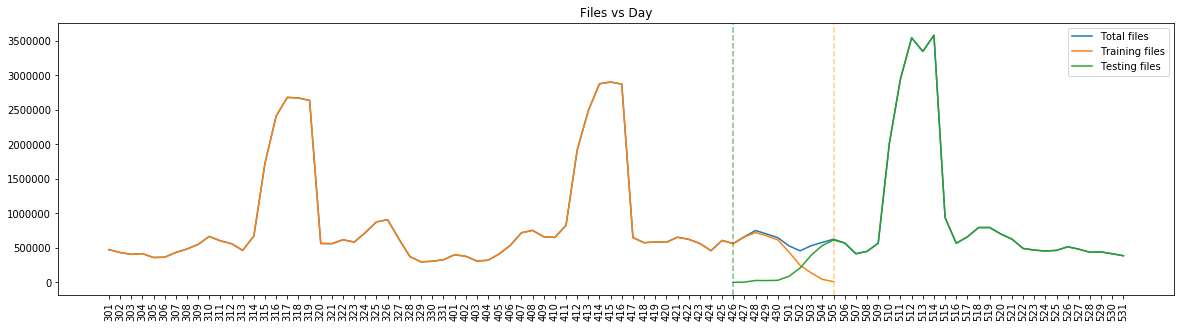

In [66]:
fig = plt.figure(figsize=(20, 5))
plt.plot(df_FileID_Day.sum(axis=0).values, label='Total files')
plt.plot(df_train_FileID_Day.iloc[:,1:].sum(axis=0).values, label='Training files')
plt.plot(df_test_FileID_Day.iloc[:,1:].sum(axis=0).values, label='Testing files')
plt.axvline(x=31+26-1, c='g', alpha=0.5, ls='--')
plt.axvline(x=31+30+5-1, c='orange', alpha=0.5, ls='--')
plt.xticks(range(len(days)), days, rotation=90)
plt.title('Files vs Day')
plt.legend()

### 2.4 (option) Virus files & nonvirus files vs Day

In [67]:
Nonvirus_Day = df_train_FileID_Day[df_train_FileID_Day['Label'] == 0].iloc[:,1:].sum(axis=0)
Virus_Day    = df_train_FileID_Day[df_train_FileID_Day['Label'] == 1].iloc[:,1:].sum(axis=0)

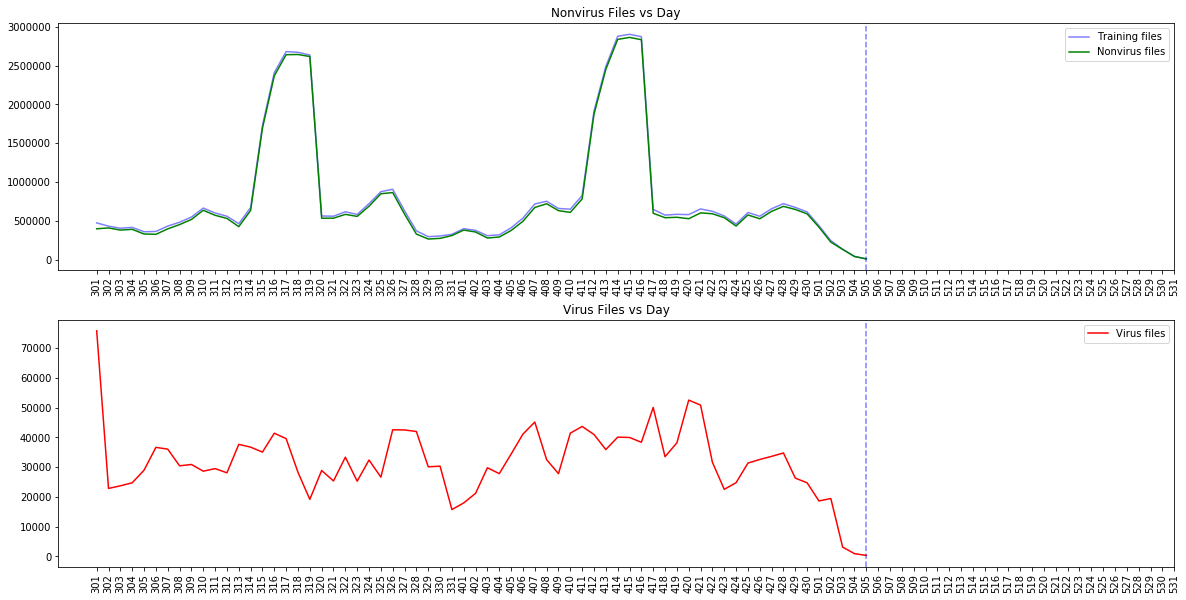

In [68]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(2,1,1)
plt.plot(df_train_FileID_Day.iloc[:,1:].sum(axis=0).values, 'b', alpha=0.5, label='Training files')
plt.plot(Nonvirus_Day.values, 'g', label='Nonvirus files')
plt.xticks(range(len(days)), days, rotation=90)
plt.title('Nonvirus Files vs Day')
plt.axvline(x=31+30+5-1, c='b', alpha=0.5, ls='--')
plt.legend()
plt.subplot(2,1,2)
plt.plot(Virus_Day.values, 'r', label='Virus files')
plt.xticks(range(len(days)), days, rotation=90)
plt.title('Virus Files vs Day')
plt.axvline(x=31+30+5-1, c='b', alpha=0.5, ls='--')
plt.legend()

### 2.5 (option) Ratio of nonvirus and virus files between total files vs Day

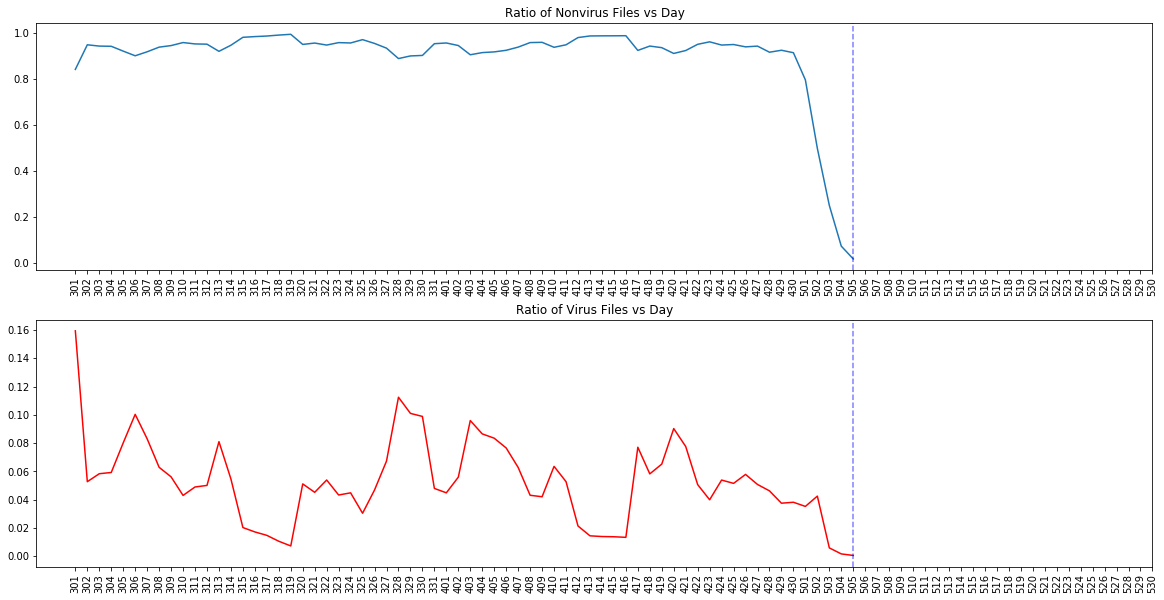

In [69]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(2,1,1)
plt.plot(Nonvirus_Day.values / df_FileID_Day.sum(axis=0).values)
plt.xticks(range(91), days, rotation=90)
plt.title('Ratio of Nonvirus Files vs Day')
plt.axvline(x=31+30+5-1, c='b', alpha=0.5, ls='--')
plt.subplot(2,1,2)
plt.plot(Virus_Day.values / df_FileID_Day.sum(axis=0).values, 'r')
plt.xticks(range(91), days, rotation=90)
plt.title('Ratio of Virus Files vs Day')
plt.axvline(x=31+30+5-1, c='b', alpha=0.5, ls='--')

In [70]:
del df_train_FileID_Day
del df_test_FileID_Day
del Nonvirus_Day
del Virus_Day

### 2.10 Weekday

In [51]:
# 2017/03/01 Wednesday

Monday_index    = range(5,len(days), 7)
Tuesday_index   = range(6,len(days), 7)
Wednesday_index = range(0,len(days), 7)
Thursday_index  = range(1,len(days), 7)
Friday_index    = range(2,len(days), 7)
Saturday_index  = range(3,len(days), 7)
Sunday_index    = range(4,len(days), 7)

In [52]:
Monday_list    = [days[i] for i in Monday_index]
Tuesday_list   = [days[i] for i in Tuesday_index]
Wednesday_list = [days[i] for i in Wednesday_index]
Thursday_list  = [days[i] for i in Thursday_index]
Friday_list    = [days[i] for i in Friday_index]
Saturday_list  = [days[i] for i in Saturday_index]
Sunday_list    = [days[i] for i in Sunday_index]

In [53]:
Weekday_dict = {'Monday': Monday_list,
                'Tuesday': Tuesday_list,
                'Wednesday': Wednesday_list,
                'Thursday': Thursday_list,
                'Friday': Friday_list,
                'Saturday': Saturday_list,
                'Sunday': Sunday_list}

In [54]:
for weekday, day_list in Weekday_dict.items():
    df_FileID_Day_features[weekday] = 0
    for day in day_list:
        df_FileID_Day_features[weekday] += df_FileID_Day[day].fillna(0)

In [64]:
df_FileID_Day_features.head()

,Max(Nonzero Day),Mean(Nonzero Day),Std(Nonzero Day),Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
FileID,,,,,,,,,,
00008c73ee43c15b16c26b26398c1577,50.0,22.333333,15.474711,50.0,22.0,21.0,20.0,19.0,2.0,0.0
0000e2398b12121a85166fed5fe2a3da,43.0,15.666667,23.692474,0.0,0.0,1.0,0.0,0.0,43.0,3.0
0001fe8dce14ce099aa6ca8ea5026ea7,66.0,39.000000,20.871033,48.0,0.0,3.0,39.0,66.0,33.0,45.0
00027f50019000accc492e5684efc818,253.0,75.600000,103.350375,0.0,10.0,253.0,27.0,80.0,8.0,0.0
00028c9da3573ec50db74b44310ae507,339.0,61.333333,136.040680,4.0,4.0,6.0,9.0,0.0,339.0,6.0


In [66]:
total = df_FileID_Day_features.iloc[:,3:].sum(axis=1)
for index in range(3, 10):
    df_FileID_Day_features.iloc[:,index] = df_FileID_Day_features.iloc[:,index] / total

In [67]:
df_FileID_Day_features.head()

,Max(Nonzero Day),Mean(Nonzero Day),Std(Nonzero Day),Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
FileID,,,,,,,,,,
00008c73ee43c15b16c26b26398c1577,50.0,22.333333,15.474711,0.373134,0.164179,0.156716,0.149254,0.141791,0.014925,0.000000
0000e2398b12121a85166fed5fe2a3da,43.0,15.666667,23.692474,0.000000,0.000000,0.021277,0.000000,0.000000,0.914894,0.063830
0001fe8dce14ce099aa6ca8ea5026ea7,66.0,39.000000,20.871033,0.205128,0.000000,0.012821,0.166667,0.282051,0.141026,0.192308
00027f50019000accc492e5684efc818,253.0,75.600000,103.350375,0.000000,0.026455,0.669312,0.071429,0.211640,0.021164,0.000000
00028c9da3573ec50db74b44310ae507,339.0,61.333333,136.040680,0.010870,0.010870,0.016304,0.024457,0.000000,0.921196,0.016304


In [69]:
df_train_FileID_Weekday = pd.merge(df_train, df_FileID_Day_features.reset_index(), on=['FileID'], how='left')
df_train_FileID_Weekday = df_train_FileID_Weekday.set_index('FileID')
df_train_FileID_Weekday = df_train_FileID_Weekday.drop('Label', axis=1)

In [70]:
df_test_FileID_Weekday = pd.merge(df_test, df_FileID_Day_features.reset_index(), on=['FileID'], how='left')
df_test_FileID_Weekday = df_test_FileID_Weekday.set_index('FileID')
df_test_FileID_Weekday = df_test_FileID_Weekday.drop('Label', axis=1)

In [118]:
df_FileID_Day_features.iloc[:,3:].to_csv('Weekday.csv')

### 2.11 Mean & std of time interval

In [73]:
def time_interval_total(list):
    return np.max(list) - np.min(list)

In [74]:
def time_interval_min(list):
    if len(list) == 1:
        return 0
    return np.min(np.diff(np.sort(list)))

In [75]:
def time_interval_max(list):
    if len(list) == 1:
        return 0
    return np.max(np.diff(np.sort(list)))

In [76]:
def time_interval_mean(list):
    if len(list) == 1:
        # There are 50 files were opened once.
        # If a file was only oppened once, we can't get the time interval. Assign 0 to it.
        return 0 # end_time - start_time
    return np.mean(np.diff(np.sort(list)))

In [77]:
def time_interval_std(list):
    if len(list) <= 2:
        # If a file was only opened twice, the number of the time interval is not sufficient to calculate std. 
        # Assign 0 to it
        return 0 #(end_time - start_time) / 2
    return np.std(np.diff(np.sort(list)))

#### Calculate the time interval 

In [78]:
df_FileID_time_interval = df_query_log.groupby('FileID')['QueryTs'].aggregate([time_interval_total, time_interval_min, time_interval_max, time_interval_mean, time_interval_std])
df_FileID_time_interval.head()

,time_interval_total,time_interval_min,time_interval_max,time_interval_mean,time_interval_std
FileID,,,,,
00008c73ee43c15b16c26b26398c1577,486146,0,58990,3655.233083,10716.700970
0000e2398b12121a85166fed5fe2a3da,373336,0,287902,8116.000000,42742.079069
0001fe8dce14ce099aa6ca8ea5026ea7,457939,6,22908,1965.403433,2880.960459
00027f50019000accc492e5684efc818,314667,0,56130,834.660477,5352.852121
00028c9da3573ec50db74b44310ae507,484109,0,80033,1319.098093,6874.384601


In [79]:
df_FileID_time_interval.describe()

,time_interval_total,time_interval_min,time_interval_max,time_interval_mean,time_interval_std
count,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000
mean,400775.367866,64.088138,59655.405341,2943.184348,8677.460473
std,140908.181284,3140.503259,69110.882196,5511.424930,12094.927520
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,377810.750000,0.000000,9951.000000,461.853456,877.304675
50%,454677.500000,0.000000,35812.000000,1362.232943,3845.564801
75%,489822.000000,0.000000,82456.750000,3794.199132,11935.821726
max,518399.000000,410702.000000,510952.000000,410702.000000,241903.000000


### (option) Distribution of time interval
    We should not consider the max of time interval as one of our features because the max of training data is much larger than 
    that of testing data.

In [72]:
df_train_FileID_time_interval = pd.merge(df_train, df_FileID_time_interval.reset_index(), on=['FileID'], how='left')
df_train_FileID_time_interval = df_train_FileID_time_interval.set_index('FileID')

In [73]:
df_test_FileID_time_interval = pd.merge(df_test, df_FileID_time_interval.reset_index(), on=['FileID'], how='left')
df_test_FileID_time_interval = df_test_FileID_time_interval.set_index('FileID')

In [74]:
pd.DataFrame({'Total': df_FileID_time_interval.sum(axis=1).describe(),
              'Training': df_train_FileID_time_interval.sum(axis=1).describe(),
              'Testing': df_test_FileID_time_interval.sum(axis=1).describe()})

,Testing,Total,Training
count,29376.000000,8.189400e+04,5.251800e+04
mean,65530.491542,7.134014e+04,7.459016e+04
std,81112.814474,8.351675e+04,8.465875e+04
min,0.500000,0.000000e+00,0.000000e+00
25%,10288.099533,1.154013e+04,1.288507e+04
50%,34031.693584,4.186423e+04,4.663396e+04
75%,90767.185193,9.929929e+04,1.032955e+05
max,851202.500000,1.232106e+06,1.232106e+06


### 2.6 (option) The total times of opening files

In [92]:
df_FileID_Day['Total(Day)'] = df_FileID_Day.sum(axis=1)
df_FileID_Day.head()

Day,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,Total(Day)
FileID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00008c73ee43c15b16c26b26398c1577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,22.0,21.0,20.0,19.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134.0
0000e2398b12121a85166fed5fe2a3da,NaN,NaN,NaN,43.0,3.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0
0001fe8dce14ce099aa6ca8ea5026ea7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,39.0,66.0,33.0,45.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,234.0
00027f50019000accc492e5684efc818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,253.0,27.0,80.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,378.0
00028c9da3573ec50db74b44310ae507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,339.0,6.0,4.0,4.0,6.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,368.0


### 2.7 (option) Check the total times of opening files

Every files have been opened at least once. So we can find the max, min, mean, std in 03/01 ~ 05/31, and the mean in the days when the files have been opened.

In [26]:
(df_FileID_Day['Total(Day)'] == 0).sum()

0

There are 50 files are only opened once.

In [27]:
(df_FileID_Day['Total(Day)'] == 1).sum()

50

### 2.11 FileID vs ProductID

In [80]:
df_FileID_ProductID = df_query_log.pivot_table(values='Times', index=['FileID'], columns='ProductID', aggfunc='sum')
df_FileID_ProductID = df_FileID_ProductID.fillna(0)

In [81]:
df_FileID_ProductID.head(1)

ProductID,0374c4,055649,05b409,0cdb7a,20f8a5,218578,262880,26a5d0,3c2be6,3ea8c3,533133,55649,634e6b,75f310,7acab3,8452da,8541a0,885fab,8b7f69,a310bb,aaa9c8,b93794,c105a0,c76d58,cc3a6a,d465fc,dd8d4a,e47f04,fec24f
FileID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00008c73ee43c15b16c26b26398c1577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,83.0,0.0


In [82]:
df_FileID_ProductID.describe()

ProductID,0374c4,055649,05b409,0cdb7a,20f8a5,218578,262880,26a5d0,3c2be6,3ea8c3,533133,55649,634e6b,75f310,7acab3,8452da,8541a0,885fab,8b7f69,a310bb,aaa9c8,b93794,c105a0,c76d58,cc3a6a,d465fc,dd8d4a,e47f04,fec24f
count,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000
mean,0.000049,64.222080,0.000073,0.002039,12.675727,0.001966,0.002772,0.266955,0.000037,21.368171,0.068186,163.502784,21.749408,0.002454,662.909554,0.001368,0.023933,3.579859,0.000024,0.312001,0.001746,3.229040,11.529831,48.615283,0.000342,0.447896,0.009024,2.315359,0.002222
std,0.008559,254.727676,0.009883,0.236402,176.711051,0.052844,0.166504,21.349453,0.006052,228.536057,0.798485,537.326549,205.189302,0.332036,1847.013403,0.106442,0.224273,54.554418,0.004942,10.335787,0.054445,129.337256,195.124084,188.852460,0.019137,2.314900,0.414298,27.429964,0.254773
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,110.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,69.000000,4.000000,0.000000,474.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,41831.000000,2.000000,48.000000,13227.000000,5.000000,31.000000,5381.000000,1.000000,30083.000000,96.000000,31289.000000,30455.000000,93.000000,62609.000000,14.000000,18.000000,9549.000000,1.000000,2200.000000,4.000000,11117.000000,41444.000000,29254.000000,2.000000,78.000000,42.000000,3082.000000,59.000000


In [83]:
df_FileID_ProductID['Total(ProductID)'] = df_FileID_ProductID.sum(axis=1)
df_FileID_ProductID.head()

ProductID,0374c4,055649,05b409,0cdb7a,20f8a5,218578,262880,26a5d0,3c2be6,3ea8c3,533133,55649,634e6b,75f310,7acab3,8452da,8541a0,885fab,8b7f69,a310bb,aaa9c8,b93794,c105a0,c76d58,cc3a6a,d465fc,dd8d4a,e47f04,fec24f,Total(ProductID)
FileID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00008c73ee43c15b16c26b26398c1577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,83.0,0.0,134.0
0000e2398b12121a85166fed5fe2a3da,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0
0001fe8dce14ce099aa6ca8ea5026ea7,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,234.0
00027f50019000accc492e5684efc818,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,2.0,88.0,0.0,146.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,378.0
00028c9da3573ec50db74b44310ae507,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,8.0,3.0,0.0,290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,368.0


In [121]:
for index in range(len(df_FileID_ProductID.columns)-1):
    df_FileID_ProductID.iloc[:,index] = df_FileID_ProductID.iloc[:,index] / df_FileID_ProductID['Total(ProductID)']

In [122]:
df_FileID_ProductID.head()

ProductID,0374c4,055649,05b409,0cdb7a,20f8a5,218578,262880,26a5d0,3c2be6,3ea8c3,533133,55649,634e6b,75f310,7acab3,8452da,8541a0,885fab,8b7f69,a310bb,aaa9c8,b93794,c105a0,c76d58,cc3a6a,d465fc,dd8d4a,e47f04,fec24f,Total(ProductID)
FileID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00008c73ee43c15b16c26b26398c1577,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.097015,0.0,0.000000,0.000000,0.0,0.134328,0.0,0.0,0.141791,0.0,0.0,0.0,0.0,0.007463,0.000000,0.0,0.0,0.0,0.619403,0.0,134.0
0000e2398b12121a85166fed5fe2a3da,0.0,0.808511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.191489,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,47.0
0001fe8dce14ce099aa6ca8ea5026ea7,0.0,0.188034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.602564,0.000000,0.0,0.017094,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.192308,0.0,0.0,0.0,0.000000,0.0,234.0
00027f50019000accc492e5684efc818,0.0,0.029101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.309524,0.0,0.005291,0.232804,0.0,0.386243,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.037037,0.000000,0.0,0.0,0.0,0.000000,0.0,378.0
00028c9da3573ec50db74b44310ae507,0.0,0.008152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.173913,0.0,0.021739,0.008152,0.0,0.788043,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,368.0


### 2.10 Check the total number of ProductID opening files

Every files have been opened at least once. So we can find the max, min, mean, std about all ProductID.

In [35]:
(df_FileID_ProductID['Total(ProductID)'] == 0).sum()

0

In [61]:
df_FileID_ProductID['Max(ProductID)'] = df_FileID_ProductID.iloc[:,:-1].max(axis=1)
df_FileID_ProductID['Mean(ProductID)'] = df_FileID_ProductID.iloc[:,:-1].mean(axis=1)
df_FileID_ProductID['Std(ProductID)'] = df_FileID_ProductID.iloc[:,:-1].std(axis=1)
df_FileID_ProductID.head()

ProductID,0374c4,055649,05b409,0cdb7a,20f8a5,218578,262880,26a5d0,3c2be6,3ea8c3,533133,55649,634e6b,75f310,7acab3,8452da,8541a0,885fab,8b7f69,a310bb,aaa9c8,b93794,c105a0,c76d58,cc3a6a,d465fc,dd8d4a,e47f04,fec24f,Total(ProductID),Max(ProductID),Mean(ProductID),Std(ProductID)
FileID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00008c73ee43c15b16c26b26398c1577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,83.0,0.0,134.0,83.0,8.933333,30.884070
0000e2398b12121a85166fed5fe2a3da,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,38.0,3.133333,12.404214
0001fe8dce14ce099aa6ca8ea5026ea7,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,234.0,141.0,15.600000,53.706330
00027f50019000accc492e5684efc818,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,2.0,88.0,0.0,146.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,378.0,146.0,25.200000,77.679836
00028c9da3573ec50db74b44310ae507,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,8.0,3.0,0.0,290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,368.0,290.0,24.533333,95.541389


### 2.13 CustomerID vs FileID

In [84]:
df_label_query_log = pd.merge(df_train, df_query_log, on='FileID', how='right')
df_label_query_log.head()

,FileID,Label,CustomerID,QueryTs,ProductID,Day,Times
0,0000e2398b12121a85166fed5fe2a3da,0.0,40664c284a10689448522bbae43c3d6f,1488608668,7acab3,0304,1
1,0000e2398b12121a85166fed5fe2a3da,0.0,40664c284a10689448522bbae43c3d6f,1488608680,7acab3,0304,1
2,0000e2398b12121a85166fed5fe2a3da,0.0,40664c284a10689448522bbae43c3d6f,1488620836,7acab3,0304,1
3,0000e2398b12121a85166fed5fe2a3da,0.0,40664c284a10689448522bbae43c3d6f,1488620844,7acab3,0304,1
4,0000e2398b12121a85166fed5fe2a3da,0.0,40664c284a10689448522bbae43c3d6f,1488630791,7acab3,0304,1


In [85]:
df_label_query_log.describe()

,Label,QueryTs,Times
count,5.425024e+07,8.327311e+07,83273110.0
mean,3.869149e-02,1.492394e+09,1.0
std,1.928587e-01,2.138802e+06,0.0
min,0.000000e+00,1.488326e+09,1.0
25%,0.000000e+00,1.490234e+09,1.0
50%,0.000000e+00,1.492291e+09,1.0
75%,0.000000e+00,1.494531e+09,1.0
max,1.000000e+00,1.496275e+09,1.0


In [86]:
df_CustomerID_FileID = df_label_query_log.groupby('CustomerID')['Label'].aggregate([len, sum])
df_CustomerID_FileID.columns = ['Total', 'Virus']
df_CustomerID_FileID['Rate'] = df_CustomerID_FileID['Virus'] / df_CustomerID_FileID['Total']
df_CustomerID_FileID = df_CustomerID_FileID.sort_values(['Rate', 'Virus'], ascending=False)
df_CustomerID_FileID.head()

,Total,Virus,Rate
CustomerID,,,
43e459853d6980b76b89174627b8d741,55960.0,55960.0,1.0
4716ab5e10a616af7b1113a926fb49c7,19201.0,19201.0,1.0
70d9af47a984732a4b589703d6eced47,8598.0,8598.0,1.0
e8421e807c45d8dee98994d34825660a,5380.0,5380.0,1.0
a9380d97edcb0e08ce8a754bc65cb002,2853.0,2853.0,1.0


In [87]:
df_CustomerID_FileID.describe()

,Total,Virus,Rate
count,5.539312e+06,4.368766e+06,4.368766e+06
mean,1.503311e+01,4.804613e-01,1.224094e-02
std,8.790220e+02,1.306210e+02,9.883062e-02
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00
50%,3.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+01,0.000000e+00,0.000000e+00
max,1.749925e+06,2.496380e+05,1.000000e+00


In [88]:
customerID_train = set(df_label_query_log[df_label_query_log['Label'].notnull()]['CustomerID'])

In [89]:
customerID_test  = set(df_label_query_log[df_label_query_log['Label'].isnull()]['CustomerID'])

In [90]:
customerID_common = customerID_train & customerID_test

### 2.12 (option) Check the distribution of CustomerID

In [16]:
print('Intersection number  :', len(customerID_common))
print('Intersection in total:', len(customerID_common) / total_CustomerID)
print('Intersection in train:', len(customerID_train & customerID_test) / len(customerID_train))
print('Union                :', len(customerID_train | customerID_test) / total_CustomerID)
print('Difference in train  :', len(customerID_train - customerID_test) / total_CustomerID)
print('Difference in test   :', len(customerID_test - customerID_train) / total_CustomerID)

Intersection number  : 1761323
Intersection in total: 0.3179678270514461
Intersection in train: 0.40316258641456193
Union                : 1.0
Difference in train  : 0.4707160383816618
Difference in test   : 0.21131613456689205


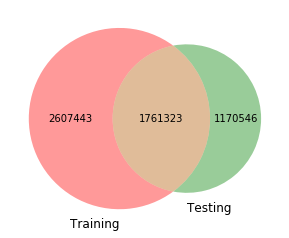

In [17]:
venn2([customerID_train, customerID_test], ('Training', 'Testing'))

### Get top 1000 dangerous CustomerID

In [91]:
df_Common_CustomerID_FileID = df_CustomerID_FileID.loc[list(customerID_common),:].sort_values(['Rate', 'Virus'], ascending=False)

In [92]:
df_Common_CustomerID_FileID.head()

,Total,Virus,Rate
CustomerID,,,
a72f39d66d5502c368294d063d222511,20676.0,20672.0,0.999807
8311f83d352a6a832da20f0e4282ddfb,2349.0,2347.0,0.999149
53a06a13b5f8a2411b5f04b52049eea2,17510.0,17495.0,0.999143
83bb804b8994c03d3b8abdeb3b921972,4050.0,4046.0,0.999012
9c62578c6bf76b795e9406317da4a7c4,799.0,798.0,0.998748


In [93]:
df_Common_CustomerID_FileID.describe()

,Total,Virus,Rate
count,1.761323e+06,1.761323e+06,1.761323e+06
mean,3.433414e+01,7.931033e-01,6.029760e-03
std,1.554667e+03,1.970384e+02,5.519055e-02
min,2.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e+00,0.000000e+00,0.000000e+00
50%,1.200000e+01,0.000000e+00,0.000000e+00
75%,3.100000e+01,0.000000e+00,0.000000e+00
max,1.749925e+06,2.496380e+05,9.998065e-01


In [94]:
top_1000_CustomerID = set(df_Common_CustomerID_FileID.index[:1000])

In [95]:
def in_top_1000_CustomerID(customerID_list):
    customerID_set = set(customerID_list)
    return 1 if len(customerID_set & top_1000_CustomerID) > 0 else 0

In [96]:
df_FileID_CustomerID = df_query_log.groupby('FileID')['CustomerID'].aggregate([in_top_1000_CustomerID])

In [97]:
df_FileID_CustomerID.head()

,in_top_1000_CustomerID
FileID,
00008c73ee43c15b16c26b26398c1577,0
0000e2398b12121a85166fed5fe2a3da,0
0001fe8dce14ce099aa6ca8ea5026ea7,0
00027f50019000accc492e5684efc818,0
00028c9da3573ec50db74b44310ae507,0


In [98]:
df_FileID_CustomerID.describe()

,in_top_1000_CustomerID
count,81894.000000
mean,0.078589
std,0.269098
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


# 3. Combine all features

In [123]:
df_features = pd.concat([# df_FileID_Day,
                         df_FileID_Day_features,
                         df_FileID_ProductID,
                         df_FileID_time_interval,
                         df_FileID_CustomerID
                        ], axis=1)
# df_features.iloc[:,:-1] = np.log(df_features.iloc[:,:-1] + 1)
df_features.describe()

,Max(Nonzero Day),Mean(Nonzero Day),Std(Nonzero Day),Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,0374c4,055649,05b409,0cdb7a,20f8a5,218578,262880,26a5d0,3c2be6,3ea8c3,533133,55649,634e6b,75f310,7acab3,8452da,8541a0,885fab,8b7f69,a310bb,aaa9c8,b93794,c105a0,c76d58,cc3a6a,d465fc,dd8d4a,e47f04,fec24f,Total(ProductID),time_interval_total,time_interval_min,time_interval_max,time_interval_mean,time_interval_std,in_top_1000_CustomerID
count,81894.000000,81894.000000,76690.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,8.189400e+04,81894.000000,8.189400e+04,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,8.189400e+04,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,8.189400e+04,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,8.189400e+04,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000,81894.000000
mean,312.771644,182.431440,114.791602,0.139611,0.131082,0.155092,0.150328,0.163523,0.133405,0.126959,4.266546e-07,0.078837,2.040028e-07,0.000018,0.038019,0.000016,0.000016,0.000358,4.007727e-08,0.065200,0.000537,0.106302,0.050139,0.000017,0.558501,0.000010,0.000162,0.009234,2.060877e-08,0.000297,0.000001,0.002463,0.039619,0.038381,9.175025e-08,0.003215,0.000082,0.008549,0.000026,1016.840184,400775.367866,64.088138,59655.405341,2943.184348,8677.460473,0.078589
std,856.708221,444.656613,360.499898,0.196993,0.197360,0.214072,0.189402,0.186974,0.161888,0.164295,7.344806e-05,0.139285,3.319720e-05,0.002370,0.128447,0.000740,0.002132,0.012175,9.151594e-06,0.110654,0.007970,0.177216,0.146059,0.001485,0.312376,0.001134,0.002007,0.055026,4.336607e-06,0.007293,0.000073,0.034649,0.143041,0.082800,6.010947e-06,0.024661,0.004230,0.051563,0.003345,2588.168735,140908.181284,3140.503259,69110.882196,5511.424930,12094.927520,0.269098
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,20.000000,14.472963,0.000000,0.000000,0.000000,0.000000,0.011364,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.302974,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,81.000000,377810.750000,0.000000,9951.000000,461.853456,877.304675,0.000000
50%,99.000000,50.500000,33.709049,0.081081,0.050847,0.094828,0.118315,0.140543,0.108696,0.090135,0.000000e+00,0.028636,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.031318,0.000000,0.000000,0.662970,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.005900,0.000000e+00,0.000000,0.000000,0.000000,0.000000,248.000000,454677.500000,0.000000,35812.000000,1362.232943,3845.564801,0.000000
75%,268.000000,147.000000,90.376942,0.197674,0.185185,0.193548,0.199293,0.222689,0.197368,0.196236,0.000000e+00,0.092491,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.094203,0.000000,0.125874,0.010870,0.000000,0.799604,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.003515,0.038835,0.000000e+00,0.000000,0.000000,0.000000,0.000000,791.000000,489822.000000,0.000000,82456.750000,3794.199132,11935.821726,0.000000
max,60995.000000,19090.000000,29319.977456,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.639344e-02,1.000000,7.575758e-03,0.521739,1.000000,0.100000,0.584906,1.000000,2.557545e-03,1.000000,1.

#### df_features has the FileID as its index. Need to transform the FileID into a column.

In [124]:
df_features = df_features.reset_index()
df_features.head(1)

,FileID,Max(Nonzero Day),Mean(Nonzero Day),Std(Nonzero Day),Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,0374c4,055649,05b409,0cdb7a,20f8a5,218578,262880,26a5d0,3c2be6,3ea8c3,533133,55649,634e6b,75f310,7acab3,8452da,8541a0,885fab,8b7f69,a310bb,aaa9c8,b93794,c105a0,c76d58,cc3a6a,d465fc,dd8d4a,e47f04,fec24f,Total(ProductID),time_interval_total,time_interval_min,time_interval_max,time_interval_mean,time_interval_std,in_top_1000_CustomerID
0,00008c73ee43c15b16c26b26398c1577,50.0,22.333333,15.474711,0.373134,0.164179,0.156716,0.149254,0.141791,0.014925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.097015,0.0,0.0,0.0,0.0,0.134328,0.0,0.0,0.141791,0.0,0.0,0.0,0.0,0.007463,0.0,0.0,0.0,0.0,0.619403,0.0,134.0,486146,0,58990,3655.233083,10716.70097,0


#### Merge the training data and all features

In [125]:
df_train_features = pd.merge(df_train, df_features, on=['FileID'], how='left')
df_train_features.head(1)

,FileID,Label,Max(Nonzero Day),Mean(Nonzero Day),Std(Nonzero Day),Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,0374c4,055649,05b409,0cdb7a,20f8a5,218578,262880,26a5d0,3c2be6,3ea8c3,533133,55649,634e6b,75f310,7acab3,8452da,8541a0,885fab,8b7f69,a310bb,aaa9c8,b93794,c105a0,c76d58,cc3a6a,d465fc,dd8d4a,e47f04,fec24f,Total(ProductID),time_interval_total,time_interval_min,time_interval_max,time_interval_mean,time_interval_std,in_top_1000_CustomerID
0,0000e2398b12121a85166fed5fe2a3da,0,43.0,15.666667,23.692474,0.0,0.0,0.021277,0.0,0.0,0.914894,0.06383,0.0,0.808511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.191489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,373336,0,287902,8116.0,42742.079069,0


#### Store df_train_features

In [51]:
df_train_features.to_csv('training&features.csv')

# 4. Load training & features data
    If you don't have the training&features.csv file, then run the all code above.

In [4]:
# set index_col=0 to get rid of 'Unnamed' column
df_train_features = pd.read_csv('training&features.csv', index_col=0)
df_train_features.head()

,FileID,Label,Max(Nonzero Day),Mean(Nonzero Day),Std(Nonzero Day),0374c4,055649,05b409,0cdb7a,20f8a5,218578,262880,26a5d0,3c2be6,3ea8c3,533133,55649,634e6b,75f310,7acab3,8452da,8541a0,885fab,8b7f69,a310bb,aaa9c8,b93794,c105a0,c76d58,cc3a6a,d465fc,dd8d4a,e47f04,fec24f,Total(ProductID),time_interval_total,time_interval_min,time_interval_max,time_interval_mean,time_interval_std,in_top_1000_CustomerID
0,0000e2398b12121a85166fed5fe2a3da,0,43.0,15.666667,23.692474,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,373336,0,287902,8116.000000,42742.079069,0
1,0001fe8dce14ce099aa6ca8ea5026ea7,0,66.0,39.000000,20.871033,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,234.0,457939,6,22908,1965.403433,2880.960459,0
2,00027f50019000accc492e5684efc818,0,253.0,75.600000,103.350375,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,2.0,88.0,0.0,146.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,378.0,314667,0,56130,834.660477,5352.852121,0
3,00028c9da3573ec50db74b44310ae507,0,339.0,61.333333,136.040680,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,8.0,3.0,0.0,290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,368.0,484109,0,80033,1319.098093,6874.384601,0
4,0003dc8130969abe688cadf5f14ea19f,0,115.0,39.166667,45.110605,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,0.0,2.0,0.0,0.0,172.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,235.0,460297,0,62842,1967.081197,6692.886778,0


In [5]:
len(df_train_features)

52518

In [79]:
# df_train_features = df_train_features.drop('Mean(Day)', axis=1)
# df_train_features.head(1)

,FileID,Label,Max(Day),Mean(Nonzero Day),Std(Day),0374c4,055649,05b409,0cdb7a,20f8a5,218578,262880,26a5d0,3c2be6,3ea8c3,533133,55649,634e6b,75f310,7acab3,8452da,8541a0,885fab,8b7f69,a310bb,aaa9c8,b93794,c105a0,c76d58,cc3a6a,d465fc,dd8d4a,e47f04,fec24f,Total(ProductID),Max(ProductID),Mean(ProductID),Std(ProductID),time_interval_min,time_interval_max,time_interval_mean,time_interval_std,in_top_1000_CustomerID
0,0000e2398b12121a85166fed5fe2a3da,0,43.0,15.666667,4.490514,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,38.0,3.133333,12.404214,0,287902,8116.0,42742.079069,0


# 5. Split data

#### Because #0 >> #1, it needs to split the training data by 

In [126]:
df_nonvirus = df_train_features[df_train_features['Label']==0]
df_virus    = df_train_features[df_train_features['Label']==1]

In [127]:
X_nonvirus = df_nonvirus.iloc[:, 2:]
y_nonvirus = df_nonvirus.iloc[:, 1]
X_virus = df_virus.iloc[:,2:]
y_virus = df_virus.iloc[:,1]
print(X_nonvirus.shape)
print(y_nonvirus.shape)
print(X_virus.shape)
print(y_virus.shape)

(46878, 46)
(46878,)
(5640, 46)
(5640,)


In [128]:
X_nonvirus_train, X_nonvirus_valid, y_nonvirus_train, y_nonvirus_valid = train_test_split(X_nonvirus, y_nonvirus, test_size=0.2)
X_virus_train, X_virus_valid, y_virus_train, y_virus_valid = train_test_split(X_virus, y_virus, test_size=0.2)

In [129]:
X_train = np.vstack([X_nonvirus_train, X_virus_train])
y_train = np.hstack([y_nonvirus_train, y_virus_train])
X_valid = np.vstack([X_nonvirus_valid, X_virus_valid])
y_valid = np.hstack([y_nonvirus_valid, y_virus_valid])

In [130]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(42014, 46)
(42014,)
(10504, 46)
(10504,)


# 6. Model

### 6.1 XGBoost

In [131]:
# original score = 0.943331009231
eval_set = [(X_valid, y_valid)]

model = XGBClassifier(learning_rate=0.1, 
                               max_depth=10, 
                               n_estimators=1000,
#                              gamma=1
#                              subsample=0.9, 
#                              colsample_bytree=0.9, 
#                              scale_pos_weight=np.sum(df_train_features.Label == 0) / np.sum(df_train_features.Label == 1)
                              )
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.90659
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.912094
[2]	validation_0-auc:0.91382
[3]	validation_0-auc:0.915757
[4]	validation_0-auc:0.918476
[5]	validation_0-auc:0.92233
[6]	validation_0-auc:0.923069
[7]	validation_0-auc:0.924531
[8]	validation_0-auc:0.925618
[9]	validation_0-auc:0.92653
[10]	validation_0-auc:0.927215
[11]	validation_0-auc:0.927187
[12]	validation_0-auc:0.928997
[13]	validation_0-auc:0.928824
[14]	validation_0-auc:0.929308
[15]	validation_0-auc:0.929768
[16]	validation_0-auc:0.931139
[17]	validation_0-auc:0.93088
[18]	validation_0-auc:0.930842
[19]	validation_0-auc:0.930897
[20]	validation_0-auc:0.932254
[21]	validation_0-auc:0.932644
[22]	validation_0-auc:0.933253
[23]	validation_0-auc:0.933842
[24]	validation_0-auc:0.934158
[25]	validation_0-auc:0.934324
[26]	validation_0-auc:0.934448
[27]	validation_0-auc:0.934729
[28]	validation_0-auc:0.935061
[29]	validation_0-auc:0.935123
[30]	validation_0-auc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [132]:
print('training score  :', roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
print('validation score:', roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1]))

training score  : 0.999011471161
validation score: 0.943543185181


In [133]:
eval_set = [(X_valid, y_valid)]

model = XGBClassifier(learning_rate=0.1, 
                               max_depth=10, 
                               n_estimators=1000,
#                              gamma=1
#                              subsample=0.9, 
#                              colsample_bytree=0.9, 
#                              scale_pos_weight=np.sum(df_train_features.Label == 0) / np.sum(df_train_features.Label == 1)
                              )
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.90659
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.912094
[2]	validation_0-auc:0.91382
[3]	validation_0-auc:0.915757
[4]	validation_0-auc:0.918476
[5]	validation_0-auc:0.92233
[6]	validation_0-auc:0.923069
[7]	validation_0-auc:0.924531
[8]	validation_0-auc:0.925618
[9]	validation_0-auc:0.92653
[10]	validation_0-auc:0.927215
[11]	validation_0-auc:0.927187
[12]	validation_0-auc:0.928997
[13]	validation_0-auc:0.928824
[14]	validation_0-auc:0.929308
[15]	validation_0-auc:0.929768
[16]	validation_0-auc:0.931139
[17]	validation_0-auc:0.93088
[18]	validation_0-auc:0.930842
[19]	validation_0-auc:0.930897
[20]	validation_0-auc:0.932254
[21]	validation_0-auc:0.932644
[22]	validation_0-auc:0.933253
[23]	validation_0-auc:0.933842
[24]	validation_0-auc:0.934158
[25]	validation_0-auc:0.934324
[26]	validation_0-auc:0.934448
[27]	validation_0-auc:0.934729
[28]	validation_0-auc:0.935061
[29]	validation_0-auc:0.935123
[30]	validation_0-auc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [134]:
print('training score  :', roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
print('validation score:', roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1]))

training score  : 0.999011471161
validation score: 0.943543185181


#### Feature importance

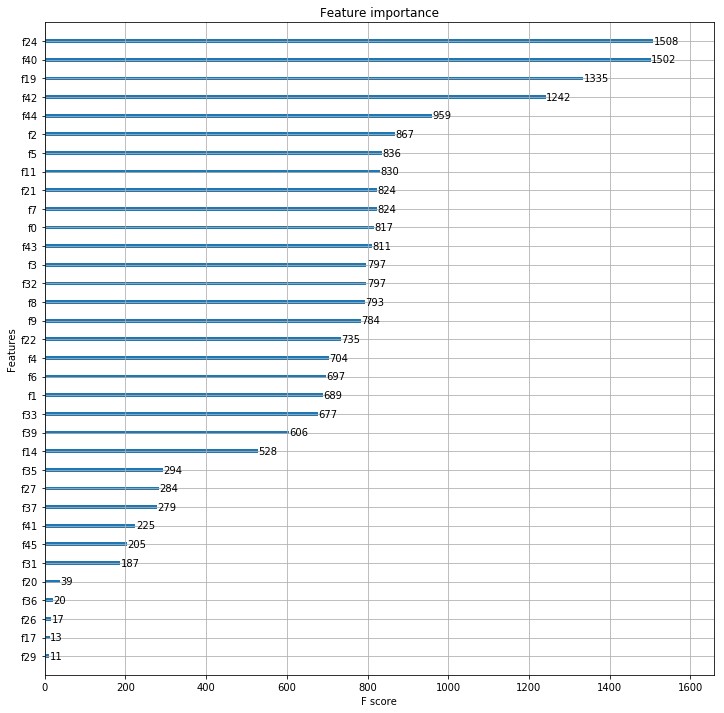

In [135]:
fig, ax = plt.subplots(figsize=(12, 12))
plot_importance(model, ax=ax)

In [136]:
model_features = list(df_train_features.columns)[2:]
feature_importances_index = model.feature_importances_.argsort()[:][::-1]
feature_importances = [model_features[index] for index in feature_importances_index]
for i in range(len(feature_importances)):
    print('f{}: {}'.format(feature_importances_index[i], feature_importances[i]))

f24: 7acab3
f40: time_interval_total
f19: 3ea8c3
f42: time_interval_max
f44: time_interval_std
f2: Std(Nonzero Day)
f5: Wednesday
f11: 055649
f7: Friday
f21: 55649
f0: Max(Nonzero Day)
f43: time_interval_mean
f3: Monday
f32: c105a0
f8: Saturday
f9: Sunday
f22: 634e6b
f4: Tuesday
f6: Thursday
f1: Mean(Nonzero Day)
f33: c76d58
f39: Total(ProductID)
f14: 20f8a5
f35: d465fc
f27: 885fab
f37: e47f04
f41: time_interval_min
f45: in_top_1000_CustomerID
f31: b93794
f20: 533133
f36: dd8d4a
f26: 8541a0
f17: 26a5d0
f29: a310bb
f12: 05b409
f34: cc3a6a
f10: 0374c4
f13: 0cdb7a
f16: 262880
f18: 3c2be6
f30: aaa9c8
f38: fec24f
f23: 75f310
f25: 8452da
f15: 218578
f28: 8b7f69


#### reweight imbalance data

In [61]:
weight = np.sum(df_train['Label'] == 0) / np.sum(df_train['Label'] == 1)
weight

8.3117021276595739

In [64]:
eval_set = [(X_valid, y_valid)]

model = XGBClassifier(learning_rate=0.1,
                      max_depth=10, 
                      n_estimators=1000, 
                      scale_pos_weight=weight)
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.904715
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.91477
[2]	validation_0-auc:0.917254
[3]	validation_0-auc:0.919769
[4]	validation_0-auc:0.92121
[5]	validation_0-auc:0.922311
[6]	validation_0-auc:0.922633
[7]	validation_0-auc:0.923211
[8]	validation_0-auc:0.924047
[9]	validation_0-auc:0.925124
[10]	validation_0-auc:0.925497
[11]	validation_0-auc:0.925945
[12]	validation_0-auc:0.926712
[13]	validation_0-auc:0.927509
[14]	validation_0-auc:0.928076
[15]	validation_0-auc:0.92819
[16]	validation_0-auc:0.928689
[17]	validation_0-auc:0.929107
[18]	validation_0-auc:0.929851
[19]	validation_0-auc:0.930159
[20]	validation_0-auc:0.930323
[21]	validation_0-auc:0.930432
[22]	validation_0-auc:0.930695
[23]	validation_0-auc:0.930705
[24]	validation_0-auc:0.930733
[25]	validation_0-auc:0.930686
[26]	validation_0-auc:0.930905
[27]	validation_0-auc:0.931312
[28]	validation_0-auc:0.931148
[29]	validation_0-auc:0.931298
[30]	validation_0-a

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=8.3117021276595739,
       seed=None, silent=True, subsample=1)

In [65]:
print('training score  :', roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
print('validation score:', roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1]))

training score  : 0.992222031255
validation score: 0.934032426612


#### Find the best parameters

In [61]:
# 'learning_rate': [0.01, 0.05, 1.0],
#               'n_estimators' : [100, 500, 1000],
#               'max_depth'    : [3, 5, 10]
parameters = {'gamma': [0, 0.5, 1]}

best_model = GridSearchCV(model, parameters, cv=5, scoring='roc_auc')
best_model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=eval_set, verbose=None)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': [0, 0.5, 1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [62]:
print('training score  :', roc_auc_score(y_train, best_model.predict_proba(X_train)[:,1]))
print('validation score:', roc_auc_score(y_valid, best_model.predict_proba(X_valid)[:,1]))

training score  : 0.990449495767
validation score: 0.93714315863


In [63]:
best_model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.5, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### 6.2 Random Decision Tree

In [74]:
model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train, y_train)
print('training score  :', roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
print('validation score:', roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1]))

training score  : 0.999999997045
validation score: 0.902976022983


# 7. Produce test data

In [52]:
df_test_features = pd.merge(df_test, df_features, on=['FileID'], how='left')
df_test_features.head()

,FileID,Label,Max(Nonzero Day),Mean(Nonzero Day),Std(Nonzero Day),0374c4,055649,05b409,0cdb7a,20f8a5,218578,262880,26a5d0,3c2be6,3ea8c3,533133,55649,634e6b,75f310,7acab3,8452da,8541a0,885fab,8b7f69,a310bb,aaa9c8,b93794,c105a0,c76d58,cc3a6a,d465fc,dd8d4a,e47f04,fec24f,Total(ProductID),time_interval_min,time_interval_max,time_interval_mean,time_interval_std,in_top_1000_CustomerID
0,00008c73ee43c15b16c26b26398c1577,0.5,50.0,22.333333,15.474711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,83.0,0.0,134.0,0,58990,3655.233083,10716.700970,0
1,0002ded3a0b54f2ffdab0ca77a5ce2b6,0.5,665.0,395.500000,381.130555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,790.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,791.0,0,159445,247.073418,5667.738256,0
2,00050a9df8e13f6ab5a3d3b3e2fc6a86,0.5,189.0,102.833333,53.997839,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,427.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0,0.0,0.0,0.0,0.0,0.0,617.0,0,14115,819.774351,1267.220106,0
3,000b1aa62b95e448784b8b341de46c64,0.5,233.0,48.400000,103.200291,0.0,32.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,193.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,242.0,0,83936,1544.248963,8816.895312,0
4,000d9f96b5eddf04a3b7a37cb95d0a00,0.5,28.0,12.166667,9.325592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,73.0,0,98093,6585.569444,17088.708998,0


In [53]:
len(df_test_features)

29376

In [54]:
X = df_test_features.iloc[:,2:]
X.head()

,Max(Nonzero Day),Mean(Nonzero Day),Std(Nonzero Day),0374c4,055649,05b409,0cdb7a,20f8a5,218578,262880,26a5d0,3c2be6,3ea8c3,533133,55649,634e6b,75f310,7acab3,8452da,8541a0,885fab,8b7f69,a310bb,aaa9c8,b93794,c105a0,c76d58,cc3a6a,d465fc,dd8d4a,e47f04,fec24f,Total(ProductID),time_interval_min,time_interval_max,time_interval_mean,time_interval_std,in_top_1000_CustomerID
0,50.0,22.333333,15.474711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,83.0,0.0,134.0,0,58990,3655.233083,10716.700970,0
1,665.0,395.500000,381.130555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,790.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,791.0,0,159445,247.073418,5667.738256,0
2,189.0,102.833333,53.997839,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,427.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0,0.0,0.0,0.0,0.0,0.0,617.0,0,14115,819.774351,1267.220106,0
3,233.0,48.400000,103.200291,0.0,32.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,193.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,242.0,0,83936,1544.248963,8816.895312,0
4,28.0,12.166667,9.325592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,73.0,0,98093,6585.569444,17088.708998,0


In [55]:
X = np.array(X)
y_pred = model.predict_proba(X)
y_pred[:5]

array([[ 0.98518467,  0.01481532],
       [ 0.84571487,  0.15428512],
       [ 0.99870086,  0.00129915],
       [ 0.99120903,  0.00879097],
       [ 0.98057401,  0.01942597]], dtype=float32)

In [56]:
df_test['Label'] = y_pred[:,1]
df_test.head()

,FileID,Label
0,00008c73ee43c15b16c26b26398c1577,0.014815
1,0002ded3a0b54f2ffdab0ca77a5ce2b6,0.154285
2,00050a9df8e13f6ab5a3d3b3e2fc6a86,0.001299
3,000b1aa62b95e448784b8b341de46c64,0.008791
4,000d9f96b5eddf04a3b7a37cb95d0a00,0.019426


In [57]:
df_test.to_csv('submission.csv', index=False, header=False)

# Functions

In [21]:
def time_hist(fileID, delta_time, df):
    df_time = df[df.iloc[:,0]==fileID][['QueryTs']]
    start_time = int(df_time.iloc[0,0])
    end_time   = int(df_time.iloc[-1,0])
    bins = [x for x in range(start_time, end_time, delta_time)]
    plt.hist(df_time.iloc[:,0], bins=bins)
#     plt.xticks(list(np.array(bins) - start_time))
    plt.title('FileID: '+fileID)

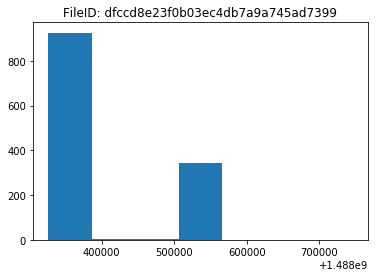

In [22]:
time_hist('dfccd8e23f0b03ec4db7a9a745ad7399', 60*1000, df_query_log)

In [52]:
def time_list(fileID, customerID, productID, df):
    df_fileID = df.loc[(df['FileID']==fileID) & (df['CustomerID']==customerID) & (df['ProductID']==productID)]['QueryTs']
    
    result = np.zeros(end_time-start_time+1)
    for j in tqdm_notebook(range(len(df_fileID))):
        result[df_fileID.iloc[j] - start_time] = 1
        
    return result

In [53]:
fileID = 'dfccd8e23f0b03ec4db7a9a745ad7399'
customerID = '64573086fcfee53e8fa6d8f1f44101bb'
productID = 'c105a0'
output = time_list(fileID, customerID, productID, df_query_log)

HBox(children=(IntProgress(value=0, max=922), HTML(value='')))

In [54]:
output[:20]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.])

In [58]:
def time_list(fileID, customerID, productID, df):
    start_time = 1488326402
    end_time   = 1496275198
    
    df_fileID = df.loc[(df.iloc[:,0]==fileID) & (df.iloc[:,1]==customerID) & (df.iloc[:,3]==productID)]['QueryTs']
    
    result = np.zeros(end_time-start_time+1)
    for j in tqdm_notebook(range(len(df_fileID))):
        result[df_fileID.iloc[j] - start_time] = 1
        
    return result

In [88]:
fileID = 'dfccd8e23f0b03ec4db7a9a745ad7399'
df_query_log.loc[df_query_log['FileID']==fileID].head()

,FileID,CustomerID,QueryTs,ProductID
0,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326402,c105a0
5,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326412,c105a0
23,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326421,c105a0
37,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326431,c105a0
39,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326441,c105a0
43,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326451,c105a0
50,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326461,c105a0
53,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326472,c105a0
62,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326482,c105a0
65,dfccd8e23f0b03ec4db7a9a745ad7399,64573086fcfee53e8fa6d8f1f44101bb,1488326491,c105a0


HBox(children=(IntProgress(value=0, max=922), HTML(value='')))

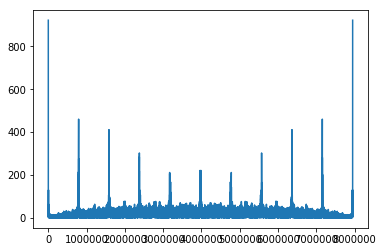

In [90]:
# label is 0 - case 1

fileID = 'dfccd8e23f0b03ec4db7a9a745ad7399'
customerID = '64573086fcfee53e8fa6d8f1f44101bb'
productID = 'c105a0'
output = time_list(fileID, customerID, productID, df_query_log)

from numpy.fft import fft
plt.plot(abs(fft(output)))

HBox(children=(IntProgress(value=0, max=1422), HTML(value='')))

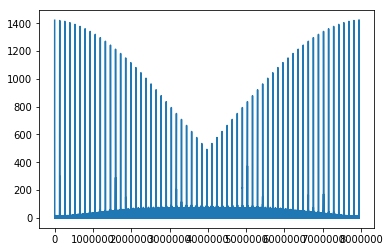

In [93]:
# label is 0 - case 2

fileID = '29962f9102502ee76bb3cddb8cf8c9ad'
customerID = '597df153a25e8e548cbe35f6e4da9cbb'
productID = 'c105a0'
output = time_list(fileID, customerID, productID, df_query_log)

plt.plot(abs(fft(output)))

HBox(children=(IntProgress(value=0, max=48), HTML(value='')))

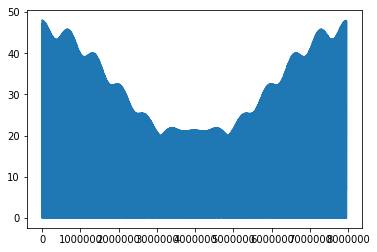

In [85]:
# label is 1 - case 1

fileID = '0005e4c0263f52453438ddd0d55aef82'
customerID = 'acbc75a1133d045877136fde7be7222b'
productID = '7acab3'
output = time_list(fileID, customerID, productID, df_query_log)

plt.plot(abs(fft(output)))

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

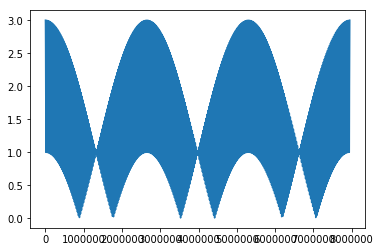

In [95]:
# label is 1 - case 2

fileID = '00117b31bd107c43123c8a0180dc036c'
customerID = '0f20dc11f6009e3855301c94af0467ea'
productID = 'c76d58'
output = time_list(fileID, customerID, productID, df_query_log)

plt.plot(abs(fft(output)))

# Appendix

### 1. get spicifit index values

In [12]:
df.loc[df_query_log['FileID']=='dfccd8e23f0b03ec4db7a9a745ad7399'].index.values

array([   0,    5,   23,   37,   39,   43,   50,   53,   62,   65,   68,
         70,   73,   75,   77,   82,   83,   87,   90,   93,   97,   99,
        100,  103,  107,  110,  116,  126,  129,  133,  137,  140,  143,
        146,  148,  152,  154,  156,  159,  162,  167,  169,  173,  175,
        177,  181,  182,  185,  191,  196,  200,  205,  210,  213,  217,
        220,  222,  224,  225,  229,  235,  241,  247,  249,  253,  256,
        261,  267,  271,  273,  276,  280,  286,  288,  291,  293,  296,
        298,  303,  307,  313,  317,  324,  327,  333,  338,  343,  348,
        352,  355,  360,  362,  370,  373,  382,  386,  392,  395,  401,
        408,  413,  416,  419,  420,  423,  427,  431,  437,  443,  448,
        452,  456,  462,  466,  472,  475,  478,  480,  481,  484,  488,
        493,  496,  498,  502,  504,  510,  513,  519,  520,  522,  525,
        529,  531,  534,  539,  542,  545,  549,  555,  559,  561,  565,
        569,  573,  576,  579,  583,  586,  590,  5

df.loc[]
df[]